## 👋 Welcome!

This is an **explanatory notebook** about

### 🖼️ *Image Filtering & Edge Detection*

---

### ✍️ Why This Notebook?

I created this notebook as a way to **practice** image filtering and edge detection concepts — while also trying to **explain them clearly** as I go.

> 🧠 This is my **first** attempt at writing an explanatory notebook, so you might come across:

* Minor mistakes
* Concepts that aren’t explained well enough
* A few rough edges
* And maybe even more :)
---

### 📌 Just a heads-up:

I’m learning as I write — so this notebook is meant to be both an **exercise in understanding** and a **resource** for anyone looking to learn the same concepts.

---

### ✅ That said... enjoy the journey!

We'll start by importing some liberaries

In [2]:
from google.colab import files
import io

import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

## **What is Filtering?**

Filtering is a fundamental image processing technique used to modify or enhance images.

By applying filters, we can:

* Sharpen or blur an image
* Smooth out noise
* Detect edges (which we’ll cover later in this notebook)

In image processing, a filter is typically a small matrix — often square-shaped — that slides across the image, applying a mathematical operation at each position.

Here's a simple illustration of how that works 🧩
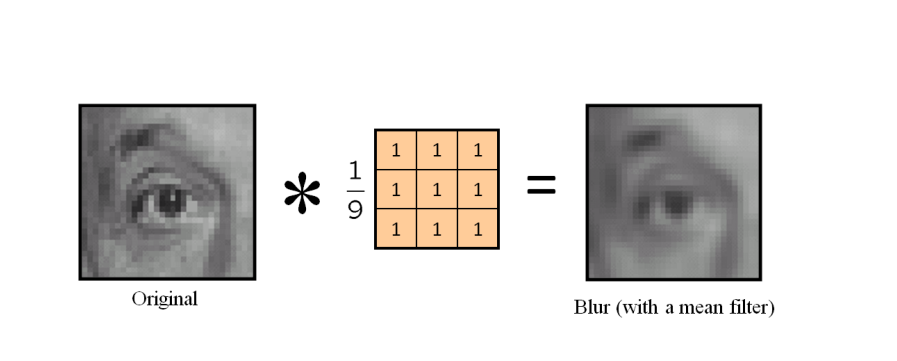

The center square represents the **filter** — also called the **kernel**.
To apply it, we **convolve** the filter over the image, which is simply a 2D array of pixel values.

To keep things clean and clear, we’ll also define a few **helper functions**.


In [3]:
# Helper function, you can ignore it because we're not using it
def upload(grayscale=True):
  uploader = files.upload()

  for fname in uploader.keys():
      image = PIL.Image.open(io.BytesIO(uploader[fname]))
      break
  return PIL.ImageOps.grayscale(image) if grayscale else image

default_filter = np.array([[1,1,1],
              [1,1,1],
              [1,1,1]])

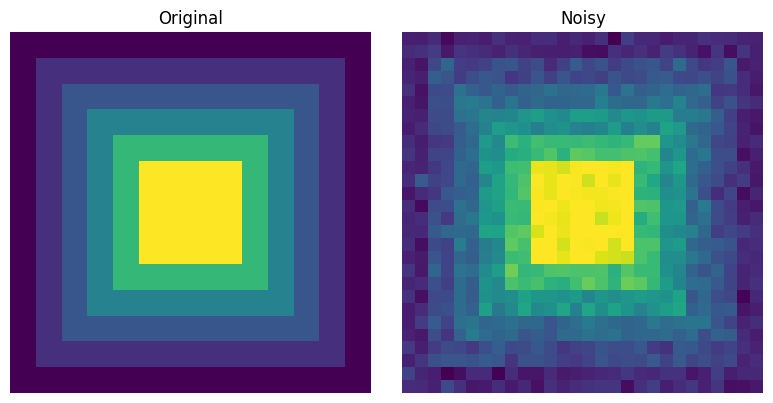

In [75]:
img = np.zeros((28, 28), dtype=np.uint8)
intensities = [30, 60, 90, 130, 180, 255]
for i, intensity in enumerate(intensities):
    padding = 2 * i
    img[padding:28-padding, padding:28-padding] = intensity

noise = np.random.normal(loc=0, scale=10, size=img.shape)
noisy_img = img + noise
noisy_img = np.clip(noisy_img, 0, 255)


fig, axis = plt.subplots(1, 2, figsize=(8, 4))

axis[0].imshow(img)
axis[0].axis('off')
axis[0].set_title('Original')

axis[1].imshow(noisy_img)
axis[1].axis('off')
axis[1].set_title('Noisy')

plt.tight_layout()
plt.show()


# **Smoothing / Blurring Filters**

Smoothing (sometimes called blurring) filters are used to reduce noise and unwanted artifacts in an image.
They help preserve important features and structures by removing small details.

However, be careful — excessive smoothing can lead to a loss of important information from the original image.

One of the most common smoothing techniques is the **Mean Filter**:

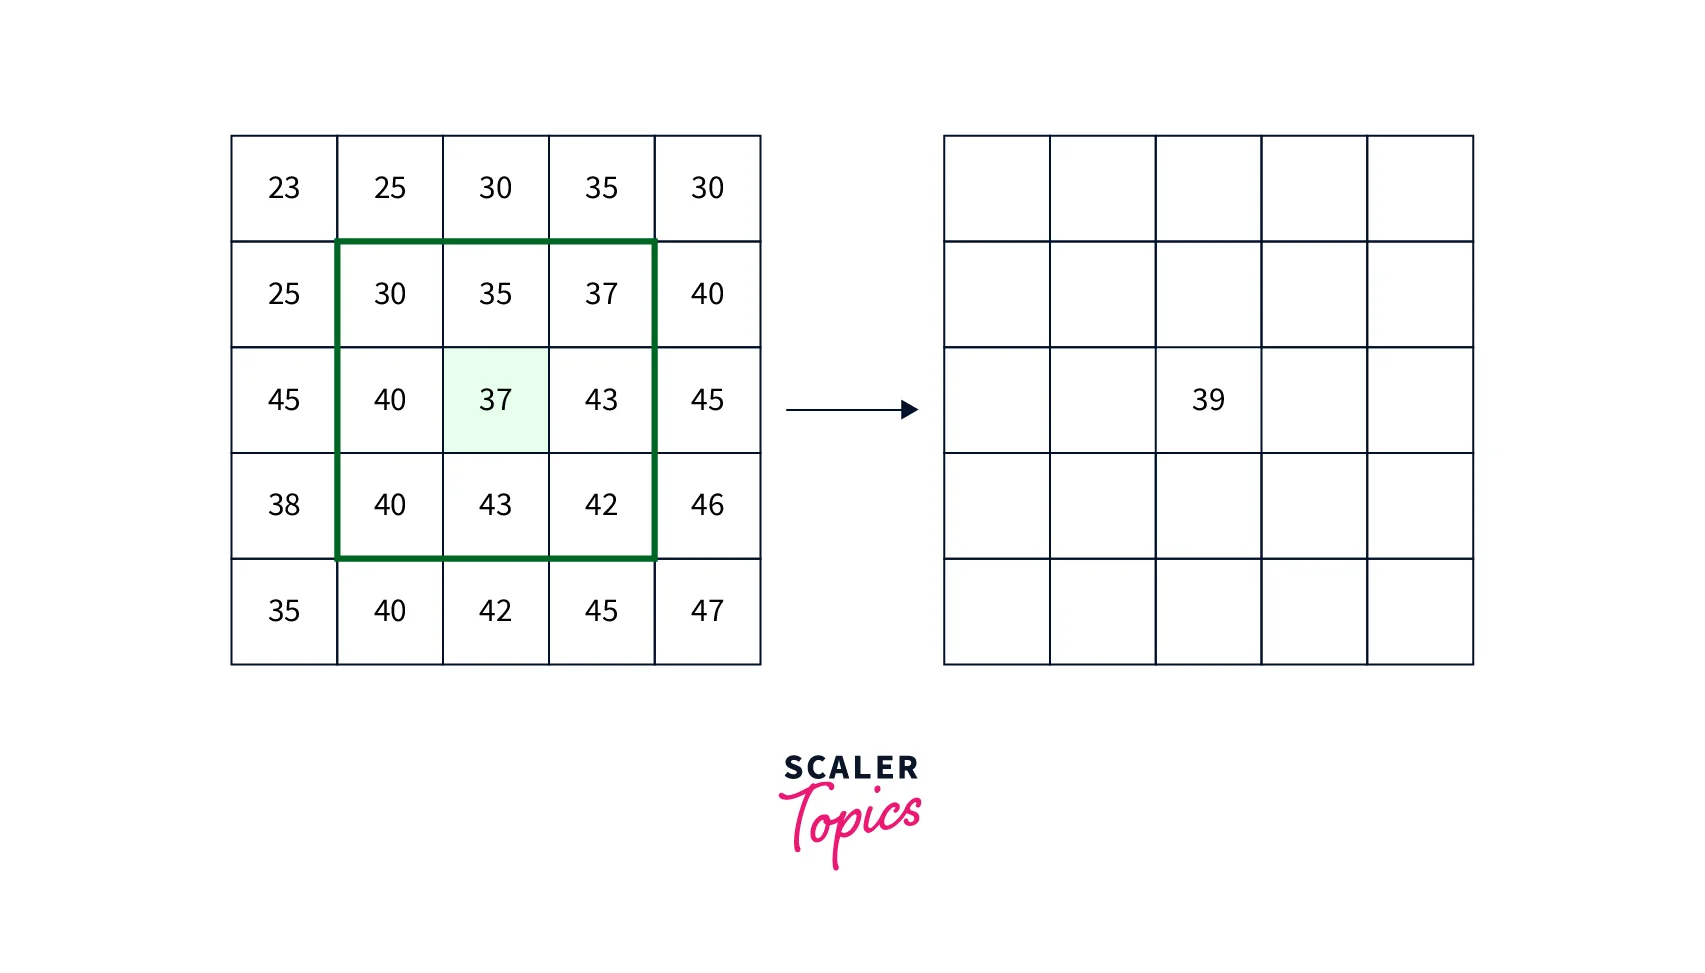

What it does is replace each original pixel value with the **average of its neighboring values** — that's why it's called the **Mean Filter**.

You're essentially mapping each pixel to a smoothed version of itself. But how can we use a filter (kernel) to do this automatically?

We need a square filter that we can convolve across the image — similar to the 3×3 green square of pixels shown above.
But what should the values inside this filter be?

Take a moment to think about it...

.

.

.

Here's your answer:

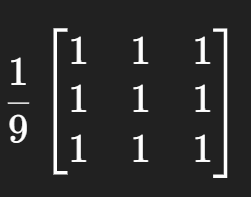

### 🧠 How It Works

We slide a **3×3 window** (kernel) over the image:

* Multiply all 9 pixels by 1 (so just sum them up).
* Divide the total by 9 (the number of pixels).

That’s it — you’re averaging!

---

### ➕ Example 1: All White

```plaintext
[255, 255, 255]
[255, 255, 255]
[255, 255, 255]
```

Sum = 2295 → 2295 / 9 = **255** → stays white.

---

### 🔻 Example 2: Top White, Bottom Black

```plaintext
[255, 255, 255]
[255, 255, 255]
[  0,   0,   0]
```

Sum = 1530 → 1530 / 9 ≈ **170** → smooths (light gray).

---

### ✅ Why It Matters

This smooths out sharp jumps, making the image softer or less noisy.

In [17]:
def convolve(img, filter=default_filter, mod="mean-smoothing"):
  # By default, it's assuming you're using 'same' convolution
  if mod == "mean-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter) / 9

  return convolved

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

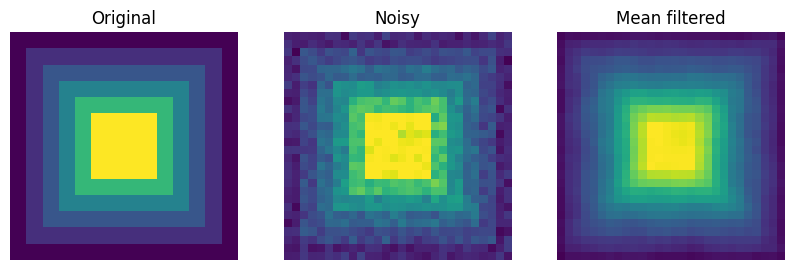

In [36]:
filter = np.array([[1,1,1],
              [1,1,1],
              [1,1,1]])
smoothed_img = convolve(noisy_img,filter)

fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(noisy_img)
ax[1].set_title("Noisy")
ax[1].axis("off")
ax[2].imshow(smoothed_img)
ax[2].set_title("Mean filtered")
ax[2].axis("off")




Great! we correctly smoothed the image, let's look at other types of smoothing filters

# **2. Median Filter**
The median filter is a nonlinear filter that works best for images with outlier noise, that is, noise on a small scale with very different colors, for example too white or too black. That's why the Median filter is one of the best filters that removes salt and pepper noise from an image. Unlike the mean filter, which is linear, the median doesn't blurr an image, instead, it preserves them while removing the noise.



> *Simply, The median filter is great for removing **salt-and-pepper noise** — those random super-white or super-black dots.*


---

### 🧠 How It Works

Instead of averaging the 3×3 window like the mean filter, we **sort the values** and take the **middle (median)** one.

✅ This keeps sharp edges clear while wiping out tiny noise dots.

---

### ➕ Example

```plaintext
[255, 255,   0]
[255,   0, 255]
[  0, 255, 255]
```

Sorted values → \[0, 0, 0, 255, 255, 255, 255, 255, 255]
**Median** → 255 → keeps the main pattern, ignores the black specks.

---

### ✅ Why It Matters

Unlike the mean filter (which can blur), the median filter **preserves details** while cleaning noise.
Pretty cool huh? 😎


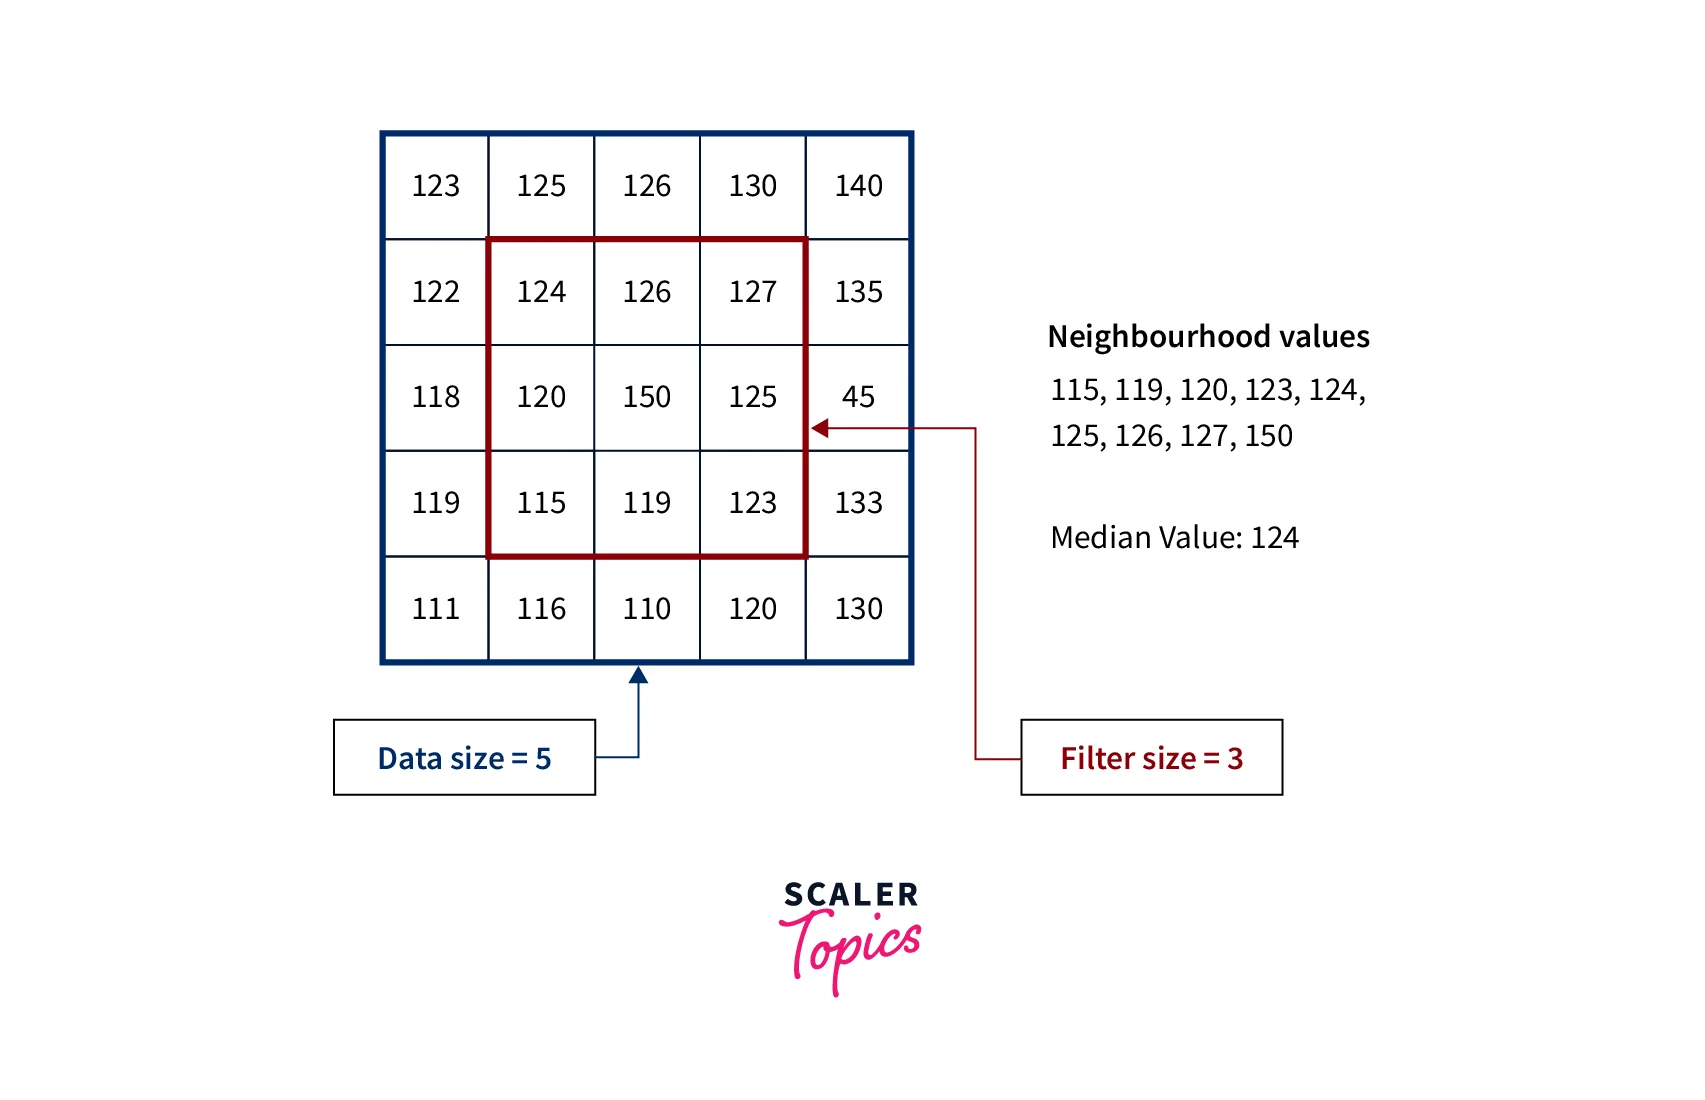

We will look at each region, and sort the valeus in them and take their median, basically.

In [37]:
def convolve(img, filter=default_filter, mod="mean-smoothing"):
  # By default, it's assuming you're using 'same' convolution
  if mod == "mean-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter) / 9

  if mod == "median-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        region = np.sort(region.flatten())
        convolved[i,j] = region[4]


  return convolved

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

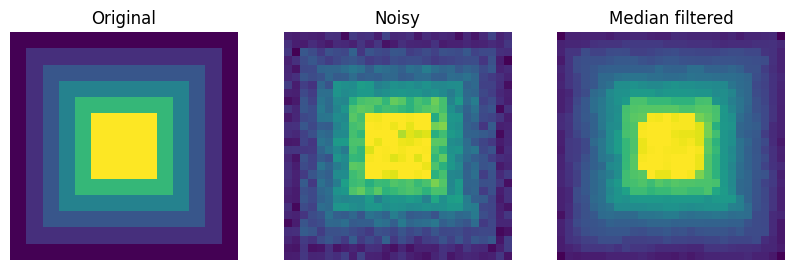

In [47]:
filter = np.array([[1,1,1],
              [1,1,1],
              [1,1,1]])
smoothed_img = convolve(noisy_img,filter, mod="median-smoothing")

fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(noisy_img)
ax[1].set_title("Noisy")
ax[1].axis("off")
ax[2].imshow(smoothed_img)
ax[2].set_title("Median filtered")
ax[2].axis("off")




Let's test it with an image with random dots as noise

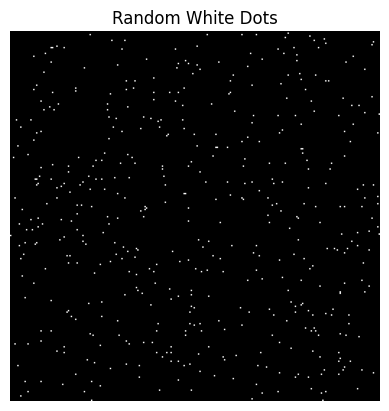

In [43]:
doted_img = np.zeros((256, 256), dtype=np.uint8)
num_dots = 500

ys = np.random.randint(0, 256, size=num_dots)
xs = np.random.randint(0, 256, size=num_dots)

doted_img[ys, xs] = 255

plt.imshow(doted_img, cmap='gray')
plt.axis('off')
plt.title("Random White Dots")
plt.show()

# image = upload()
# image = np.array(image)
# image = image[125:600, 450:1000]
# plt.imshow(image , cmap = "gray")

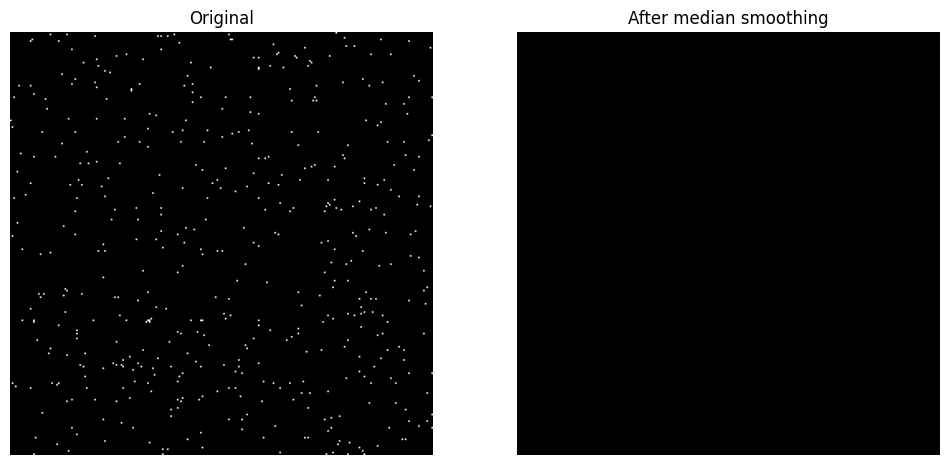

In [41]:
convolved = convolve(doted_img, mod="median-smoothing")
figure, axis = plt.subplots(1, 2, figsize=(12,6))

axis[0].imshow(doted_img, cmap = "gray")
axis[0].set_title("Original")

axis[1].imshow(convolved, cmap = "gray")
axis[1].set_title("After median smoothing")

axis[0].axis("off")
axis[1].axis("off")
plt.show()

It worked! The random small dots in the original image are now gone.

---
# **3. Gaussion Filter**

The Gaussian filter smooths images **using a bell-shaped (Gaussian) weight** — it’s like a smarter mean filter.

---

### 🧠 How It Works

* Each pixel in the 3×3 (or bigger) window gets a weight based on its distance from the center.
* Closer pixels matter **more**, farther pixels matter **less**.
* Multiply, sum up — done.

✅ No dividing like in the mean filter; the weights already handle it.

---

### ➕ Why Gaussian?

It smooths gently, keeping important edges while reducing noise — making it better for natural-looking blur.

---

### 🤔OK, so how am I going to get the gaussion filter?

Just compute it using this formula for the gaussion distribution



$$
G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$
* $x, y$: coordinates (centered at 0)
* $\sigma$: standard deviation
* The kernel is built by evaluating this formula for each pixel $(x, y)$ in the kernel grid

X & Y are just the distance from the center of the kernal to the coordiantes you're at



In [44]:
def gaussion_filter(size=3):

  filter = np.zeros((size, size))
  center =  size // 2

  def G(x,y, c=center, sigma=0.85):
    x = x - c
    y = y - c
    return (1/(2 * np.pi * (sigma**2))) * (np.exp(-(((x**2) + (y**2))/(2 * (sigma**2)))))

  for x in range(size):
    for y in range(size):
      filter[x,y] = G(x,y)

  filter /= np.sum(filter) # test without


  return filter


def convolve(img, filter=default_filter, mod="mean-smoothing"):
  # By default, it's assuming you're using 'same' convolution
  if mod == "mean-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter) / 9

  if mod == "median-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        region = np.sort(region.flatten())
        convolved[i,j] = region[4]

  if mod == "gaussion-filter":

    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter)

  return convolved

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

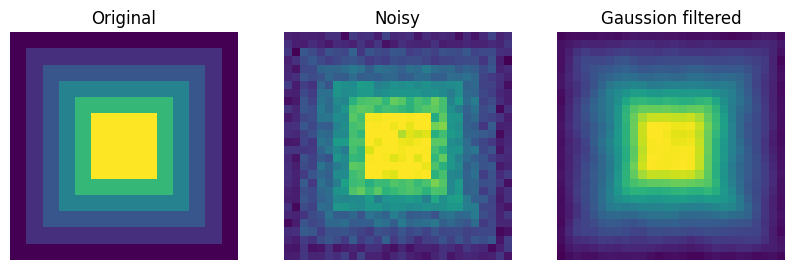

In [51]:
filter = np.array([[1,1,1],
              [1,1,1],
              [1,1,1]])
smoothed_img = convolve(noisy_img, filter=gaussion_filter(), mod="gaussion-filter")

fig, ax = plt.subplots(1,3, figsize=(10,8))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(noisy_img)
ax[1].set_title("Noisy")
ax[1].axis("off")
ax[2].imshow(smoothed_img)
ax[2].set_title("Gaussion filtered")
ax[2].axis("off")





In [61]:

# fig, axis = plt.subplots(7, 2, figsize=(10, 20))
# for i, j in enumerate([5, 21, 51, 101, 151, 201, 255]):
#   axis[i, 1].imshow(convolve(img, filter=gaussion_filter(size=j), mod="gaussion-filter"))
#   axis[i, 1].set_title(f"size: {j} ")
#   axis[i, 1].axis("off")
#   axis[i, 0].imshow(img)
#   axis[i, 0].set_title(f"Original")
#   axis[i, 0].axis("off")


# plt.show()

Let's visualize gaussian filter it self

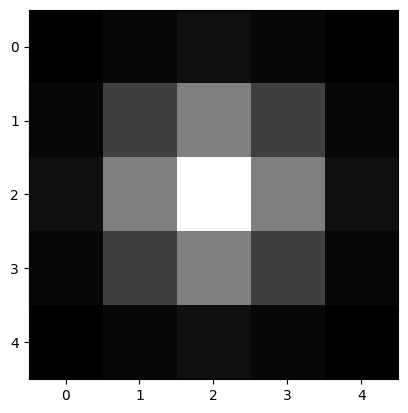

In [18]:
def gaussion_filter(size=3):

  filter = np.zeros((size, size))
  center =  size // 2

  def G(x,y, c=center, sigma=0.85):
    x = x - c
    y = y - c
    return (1/(2 * np.pi * (sigma**2))) * (np.exp(-(((x**2) + (y**2))/(2 * (sigma**2)))))

  for x in range(size):
    for y in range(size):
      filter[x,y] = G(x,y)

  filter /= np.sum(filter) # test without


  return filter
plt.imshow(gaussion_filter(size=5), cmap="gray")

What happens when we repeart the gaussion filter recursively on an image?
Let's find out

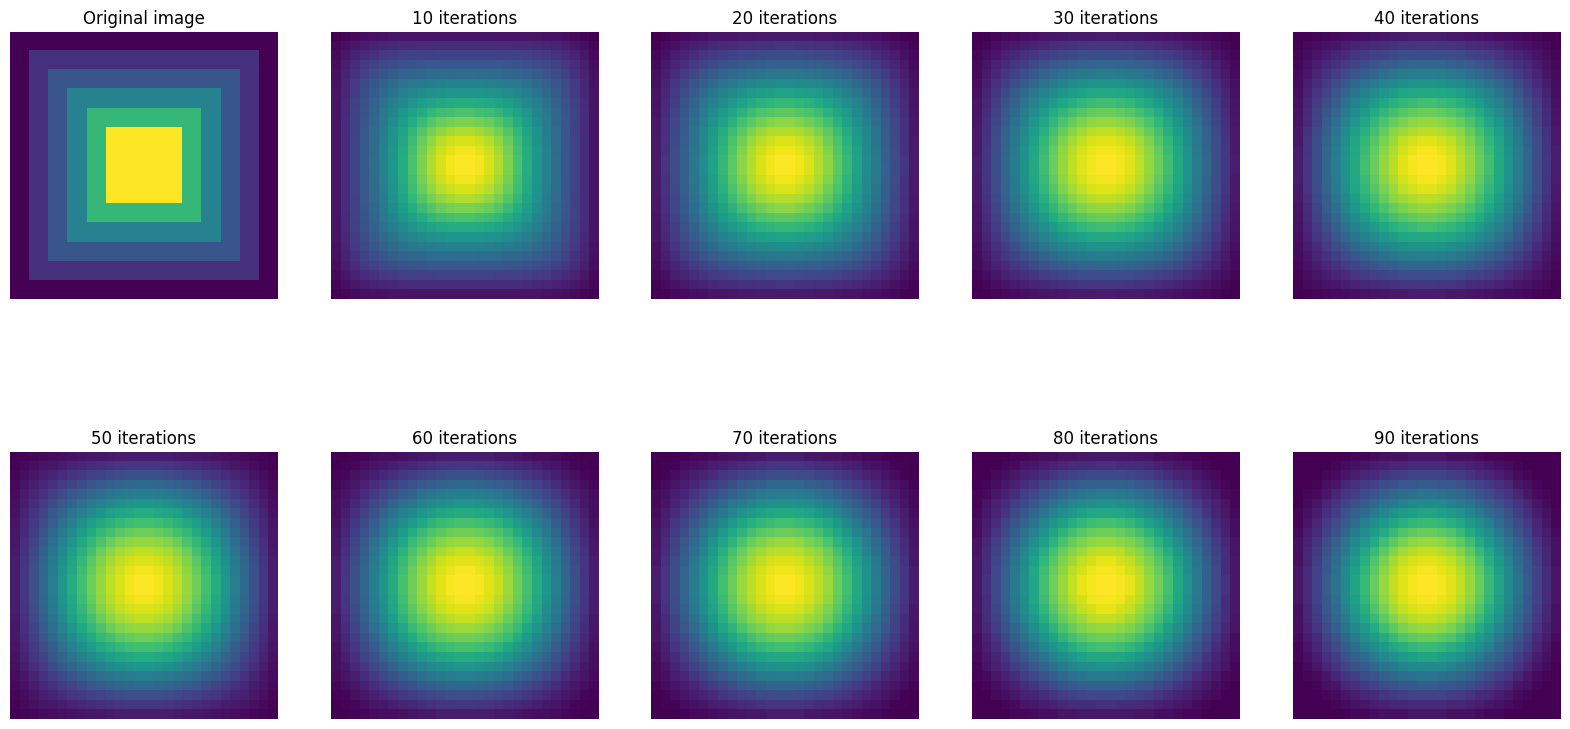

In [72]:
fig, axis = plt.subplots(2, 5, figsize=(20, 10))
axis = axis.flatten()
axis[0].imshow(img)
axis[0].axis("off")
axis[0].set_title("Original image")

current_img = img
for i in range(1, 100):
    current_img = convolve(current_img, filter=gaussion_filter(size=5), mod="gaussion-filter")
    if i % 10 == 0:
        index = i // 10
        axis[index].imshow(current_img)
        axis[index].axis("off")
        axis[index].set_title(f"{i} iterations")


---
Let us now compare between all these filters


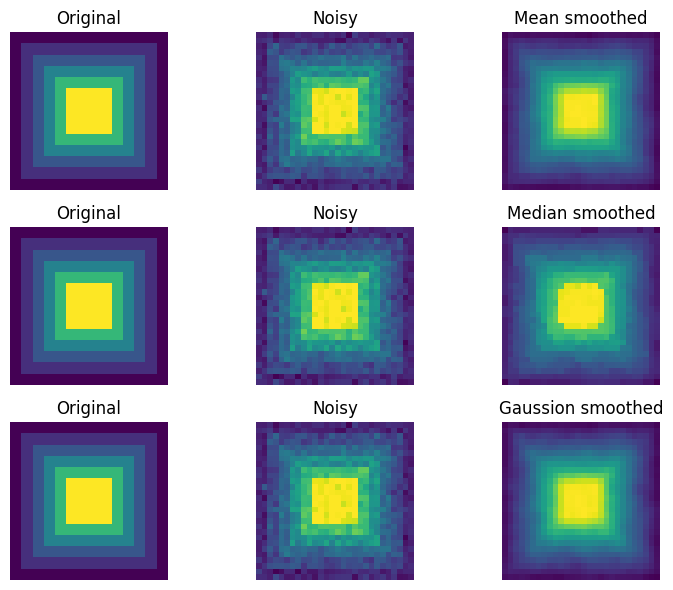

In [80]:
fig, ax = plt.subplots(3, 3, figsize=(8, 6))
ax = ax.flatten()

# Row 1: Mean Smoothing
ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(noisy_img)
ax[1].set_title("Noisy")
ax[1].axis("off")

mean_kernel = np.ones((3, 3))
mean_smoothed = convolve(noisy_img, filter=default_filter, mod="mean-smoothing")
ax[2].imshow(mean_smoothed)
ax[2].set_title("Mean smoothed")
ax[2].axis("off")

ax[3].imshow(img)
ax[3].set_title("Original")
ax[3].axis("off")

ax[4].imshow(noisy_img)
ax[4].set_title("Noisy")
ax[4].axis("off")

median_smoothed = convolve(noisy_img, filter=default_filter, mod="median-smoothing")
ax[5].imshow(median_smoothed)
ax[5].set_title("Median smoothed")
ax[5].axis("off")

ax[6].imshow(img)
ax[6].set_title("Original")
ax[6].axis("off")

ax[7].imshow(noisy_img)
ax[7].set_title("Noisy")
ax[7].axis("off")

gaussian_kernel = gaussion_filter(size=3)
gaussian_smoothed = convolve(noisy_img, filter=gaussion_filter(), mod="gaussion-filter")
ax[8].imshow(gaussian_smoothed)
ax[8].set_title("Gaussion smoothed")
ax[8].axis("off")

plt.tight_layout()
plt.show()


---
# **Edge Detectors**
an edge is a sudden change in intensity or color in an image. Jumpping from black to white or the opposite of that in 2 naighboring pexils is one example of an edge.

*Why are we detecting edges?*

Good question. Vision models, often work with detecting objects, and detecting the edges of certin objects is one critical thing. So, edge detection can help us detect certin objects and draw their boundries, shapes, and texture.

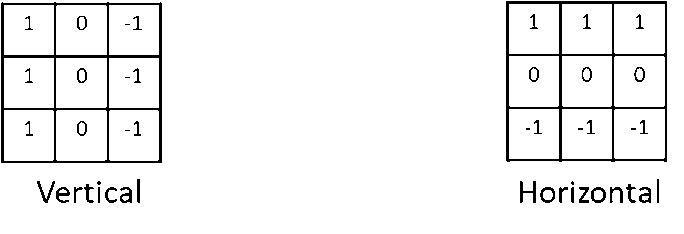

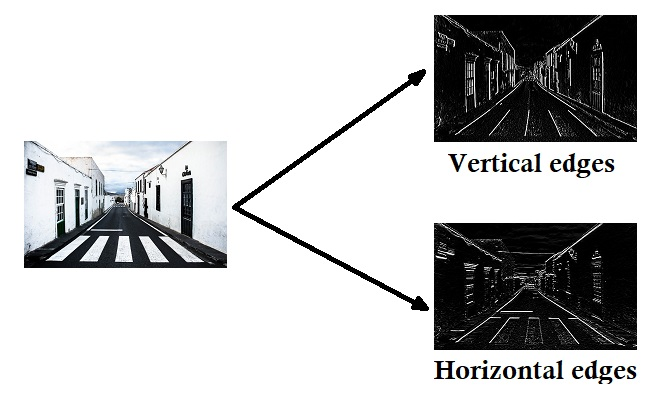

### 🔍 Basic Example of Edge Detection

This is one basic example of edge detection, and the results are self-explanatory — but the filters might feel a little ambiguous at first.

Let’s focus on the **vertical edge detector**.

---

### 🧠 How It Works

The filter works by examining each **3×3 region** of the image:

* The **middle row** is zeroed out — we're expecting an edge to appear there.
* The **top row** is multiplied by `+1`.
* The **bottom row** is multiplied by `-1`.

#### ➕ Case 1: No Edge (Uniform Region)

If the region happens to lie in a uniform area (like a white background), all pixel values will be similar. For example:

```plaintext
Top:    [255, 255, 255]  → multiplied by +1
Middle: [255, 255, 255]  → multiplied by  0
Bottom: [255, 255, 255]  → multiplied by -1
```

The result is:

```
(+255 +255 +255) + (0) + (-255 -255 -255) = 0
```

So, **no edge is detected**.

---

#### 🔻 Case 2: Edge Detected (Sharp Contrast)

Now imagine a region where the top is very bright (255) and the bottom is very dark (0):

```plaintext
Top:    [255, 255, 255]
Middle: [128, 128, 128]  ← ignored
Bottom: [  0,   0,   0]
```

You get:

```
(+255 +255 +255) + (0) + ( 0 + 0 + 0) = 765
```

The result is large — so **an edge is detected**.

---

### ❓ What If the Result Is Negative?

That’s a good question.

It simply means the **intensity increases downward** (e.g., dark above and bright below). For example:

```plaintext
Top: [0, 0, 0]
Bottom: [255, 255, 255]
```

Gives:

```
(0) - (255 + 255 + 255) = -765
```

### ✅ Solution

We don’t care **which direction** the edge goes — up or down. So we just take the **absolute value**:

```python
edge_strength = np.abs(convolution_result)
```

This ensures we always highlight the presence of an edge regardless of direction.



---
Now let's try and code that.


In [96]:
# Just adding the 'default' mod in convolve()
def convolve(img, filter=default_filter, mod="default"):

  if mod == "default":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.abs(np.sum(region * filter))

  # By default, it's assuming you're using 'same' convolution
  if mod == "mean-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter) / 9

  if mod == "median-smoothing":
    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        region = np.sort(region.flatten())
        convolved[i,j] = region[4]

  if mod == "gaussion-filter":

    convolved = np.zeros_like(img)

    h, w = img.shape
    f_h, f_w = filter.shape

    img = np.pad(img, pad_width=f_w//2, mode='constant', constant_values=0)

    for i in range(h):
      for j in range(w):
        region = img[i:i+f_h, j:j+f_w]
        convolved[i,j] = np.sum(region * filter)

  return convolved



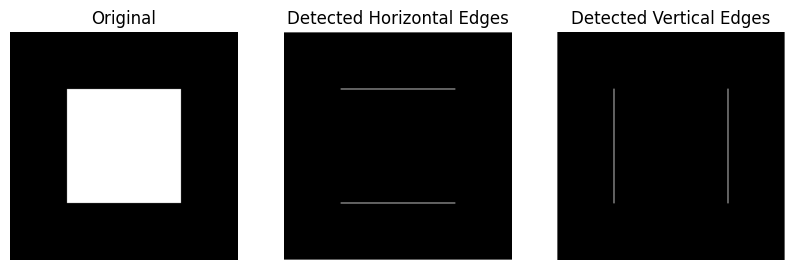

In [108]:
h_detector = np.array([ [1, 1, 1],
                        [0 ,0 ,0],
                        [-1,-1,-1]])

v_detector = np.array([[1, 0,-1],
                       [1, 0,-1],
                       [1, 0,-1]])

img = np.ones((600, 600), dtype=np.uint8) * 255

start = 150
end = 450

img[start:end, start:end] = 0

_, ax = plt.subplots(1, 3, figsize=(10,6))

ax[0].imshow(img, cmap='gray_r')
ax[0].set_title("Original")
ax[0].axis("off")
ax[1].imshow(convolve(img, h_detector), cmap ='gray')
ax[1].set_title("Detected Horizontal Edges")
ax[1].axis("off")
ax[2].imshow(convolve(img, v_detector), cmap ='gray')
ax[2].set_title("Detected Vertical Edges")
ax[2].axis("off")

plt.show()

That was great, but what if we had a circle? it has diagonal edges as well. To detect diagonal edges, we can use **Roberts Cross kernels/filters**, $G_x$ and $G_y$:

$$
G_x = \begin{bmatrix}
+1 & 0 \\
0 & -1
\end{bmatrix}
$$

$$
G_y = \begin{bmatrix}
0 & +1 \\
-1 & 0
\end{bmatrix}
$$


*Why do we need two matrecis?*

Similar to a horizontal and vertical edge detection. Just think of it as rotating the image 45 degrees and doing straight edge detection, you'll need both horizontal and vertical. Therfore, without rotating anything, you'll need to account for 2 diagonal detectors.

In [ ]:
# Creating a circle
img = np.ones((1000, 1000), dtype=np.uint8) * 255

Y, X = np.ogrid[:1000, :1000]
dist_from_center = np.sqrt((X - 500)**2 + (Y - 500)**2)

mask = dist_from_center <= 400
img[mask] = 0

In [ ]:
gx = np.array([[1, 0],
               [0,-1]])

gy = np.array([[0, 1],
               [-1,0]])

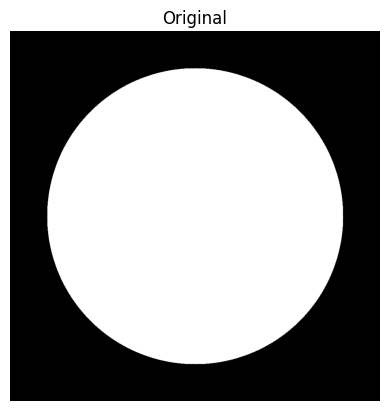

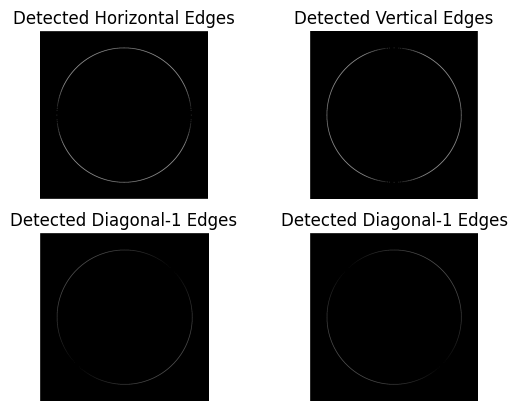

In [123]:
plt.imshow(img, cmap='gray_r')
plt.axis('off')
plt.title("Original")
plt.show()

_, ax = plt.subplots(2, 2)
ax = ax.flatten()

ax[0].imshow(convolve(img, h_detector), cmap ='gray')
ax[0].set_title("Detected Horizontal Edges")
ax[0].axis("off")

ax[1].imshow(convolve(img, v_detector), cmap ='gray')
ax[1].set_title("Detected Vertical Edges")
ax[1].axis("off")

ax[2].imshow(convolve(img, gx), cmap ='gray')
ax[2].set_title("Detected Diagonal-1 Edges")
ax[2].axis("off")


ax[3].imshow(convolve(img, gy), cmap ='gray')
ax[3].set_title("Detected Diagonal-1 Edges")
ax[3].axis("off")

plt.show()

plt.imshow()

plt.imshow(convolve(img, h_detector) + convolve(img, v_detector) + convolve(img, gx)+ convolve(img, gy), cmap = "gray")
plt.title("All the detection compined")

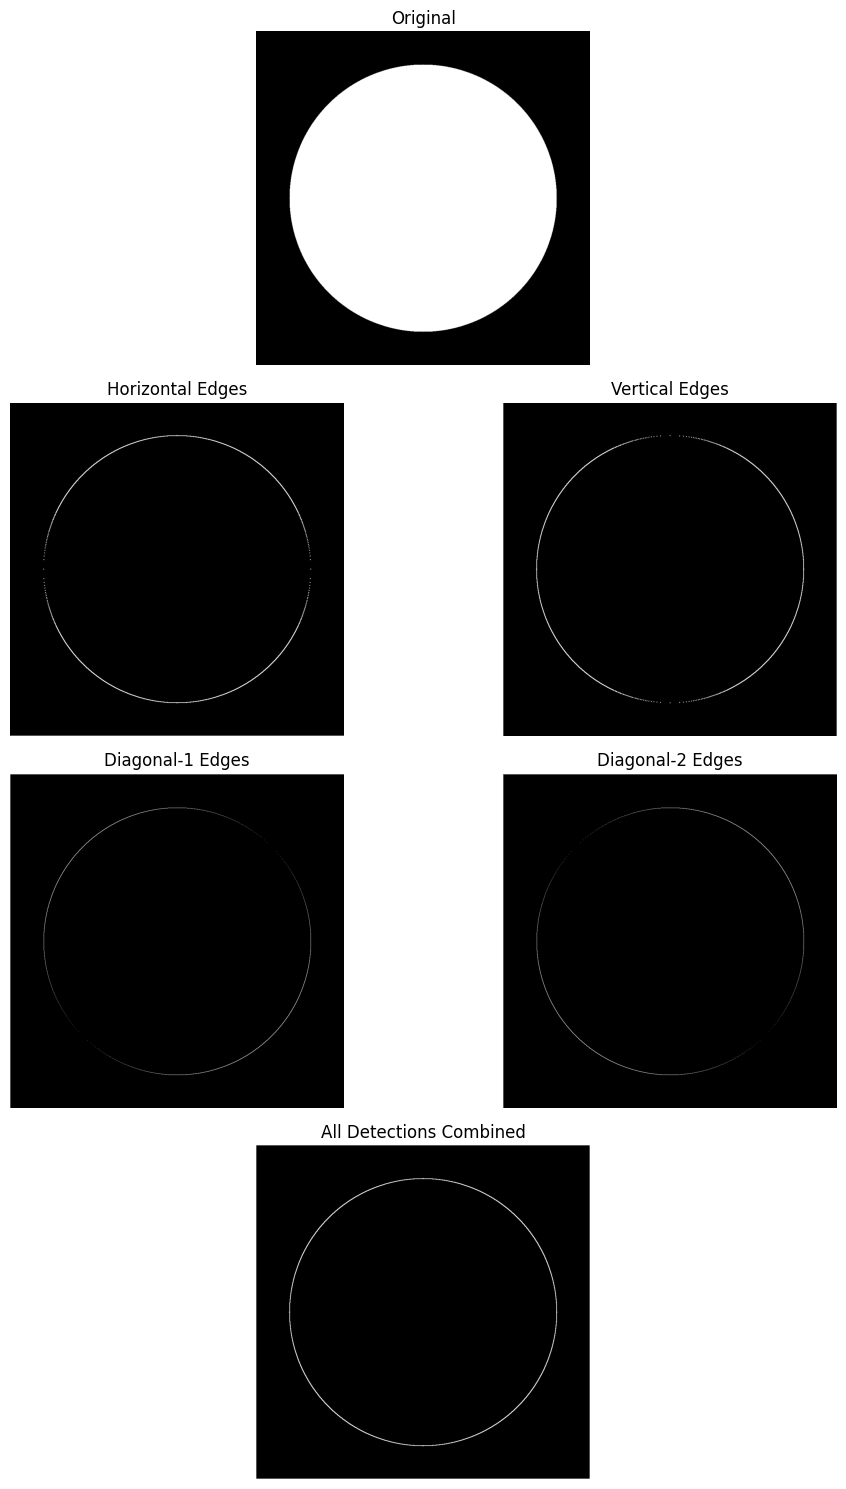

In [126]:
fig = plt.figure(figsize=(10, 15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.imshow(img, cmap='gray_r')
ax1.set_title("Original")
ax1.axis('off')

ax2 = fig.add_subplot(4, 2, 3)
ax2.imshow(convolve(img, h_detector), cmap='gray')
ax2.set_title("Horizontal Edges")
ax2.axis('off')

ax3 = fig.add_subplot(4, 2, 4)
ax3.imshow(convolve(img, v_detector), cmap='gray')
ax3.set_title("Vertical Edges")
ax3.axis('off')

ax4 = fig.add_subplot(4, 2, 5)
ax4.imshow(convolve(img, gx), cmap='gray')
ax4.set_title("Diagonal-1 Edges")
ax4.axis('off')

ax5 = fig.add_subplot(4, 2, 6)
ax5.imshow(convolve(img, gy), cmap='gray')
ax5.set_title("Diagonal-2 Edges")
ax5.axis('off')

ax6 = fig.add_subplot(4, 1, 4)
ax6.imshow(convolve(img, h_detector) + convolve(img, v_detector) + convolve(img, gx) + convolve(img, gy), cmap='gray')
ax6.set_title("All Detections Combined")
ax6.axis('off')

plt.tight_layout()
plt.show()


### 🎉 You’ve reached the end!

Thanks for reading — I hope you enjoyed it!

If you have any feedback or thoughts, feel free to reach out:

* **GitHub:** [https://github.com/Qasim-11](https://github.com/Qasim-11)
* **LinkedIn:** [https://www.linkedin.com/in/qasim-mahfood-10a0bb212/](https://www.linkedin.com/in/qasim-mahfood-10a0bb212/)


---

### 📚 References

* [Scaler: Smoothing in Image Processing](https://www.scaler.com/topics/smoothing-in-image-processing/)
* [Cornell CS1114: Convolution Notes (PDF)](https://www.cs.cornell.edu/courses/cs1114/2013sp/sections/S06_convolution.pdf)
* [SciPy Lectures: Advanced Image Processing](https://scipy-lectures.org/advanced/image_processing/)
* [GeeksforGeeks: Comprehensive Guide to Edge Detection Algorithms](https://www.geeksforgeeks.org/comprehensive-guide-to-edge-detection-algorithms/)
